# INF367 Mandatory 2

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
from src import Model1, Model2, Model3, circuit1, circuit2, circuit3

In [2]:
SEED = 367

## Data exploration and pre-processing

In [3]:
X, y = load_iris(return_X_y=True)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=.7, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=.5, random_state=SEED)
print("Training size: ", len(X_train))
print("Validation size: ", len(X_val))
print("Test size: ", len(X_test))

Training size:  105
Validation size:  22
Test size:  23


In [4]:
print("Features shape: ",X_train.shape)
print("Target shape: ",y_train.shape)
print(f"Feature value range: {np.min(X_train)} : {np.max(X_train)}")

Features shape:  (105, 4)
Target shape:  (105,)
Feature value range: 0.1 : 7.9


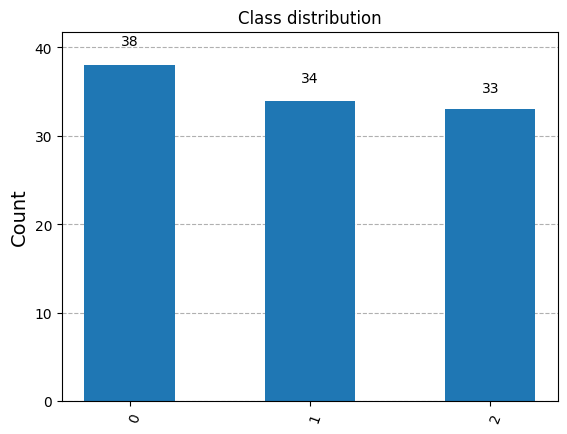

In [5]:
plot_histogram(Counter(y_train), title="Class distribution")

In [6]:
scaler = MinMaxScaler(feature_range=(0,np.pi))
X_train = scaler.fit_transform(X_train)

## QNN-circuits

In [7]:
_features = [0.4, 0.3, 0.1, 0.2] # Only for display purposes

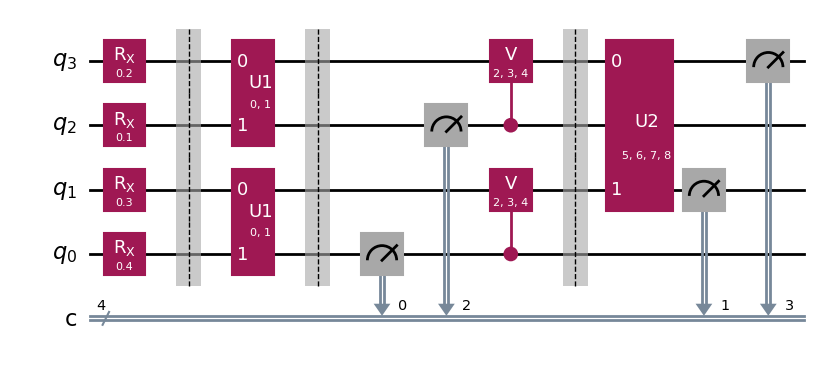

In [8]:
# Circuit 1
circ1 = circuit1(_features)
circ1.draw("mpl", reverse_bits=True, filename="images/circuit1.png")

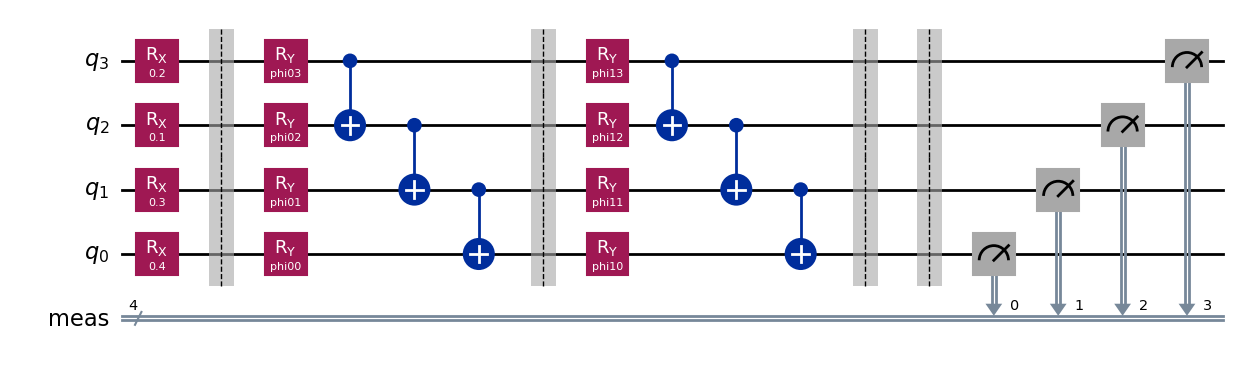

In [9]:
# Circuit 2
circ2 = circuit2(_features, layers=2)
circ2.draw("mpl", reverse_bits=True, filename="images/circuit2.png")

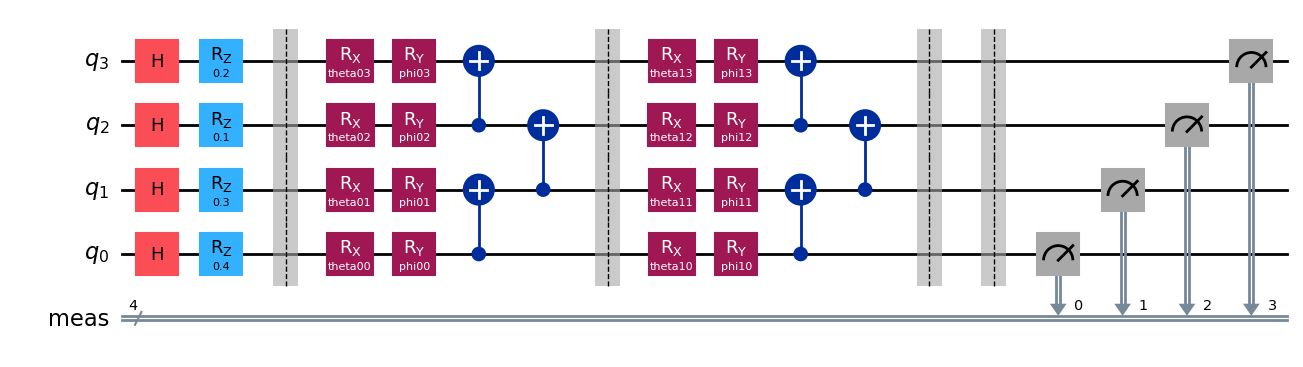

In [10]:
# Circuit 3
circ3 = circuit3(_features, layers=2)
circ3.draw("mpl", reverse_bits=True, filename="images/circuit3.png")

## Training and Validation

In [11]:
models = []
model_accuracies = []

epochs = 20

hyper_parameters = [
    (Model1, {"learning_rate": 1.2, "epsilon": 0.7}),
    (Model1, {"learning_rate": 1.4, "epsilon": 0.4}),
    (Model1, {"learning_rate": 0.9, "epsilon": 0.8}),
    (Model1, {"learning_rate": 1.5, "epsilon": 0.9}),
    (Model2, {"learning_rate": 1.2, "epsilon": 0.7, "layers": 2}),
    (Model2, {"learning_rate": 1.4, "epsilon": 0.4, "layers": 5}),
    (Model2, {"learning_rate": 0.9, "epsilon": 0.8, "layers": 4}),
    (Model2, {"learning_rate": 1.5, "epsilon": 0.9, "layers": 3}),
    (Model3, {"learning_rate": 1.2, "epsilon": 0.7, "layers": 2}),
    (Model3, {"learning_rate": 1.4, "epsilon": 0.4, "layers": 5}),
    (Model3, {"learning_rate": 0.9, "epsilon": 0.8, "layers": 4}),
    (Model3, {"learning_rate": 1.5, "epsilon": 0.9, "layers": 3}),
]


for architecture, hyper_params in hyper_parameters:
    print(f"Model architecture: {architecture}")
    [print(f"{k}: {v}, ", end="") for k,v in hyper_params.items()]
    print()
    model = architecture(gradient_shots=1000, seed=SEED, **hyper_params)
    model = model.fit(epochs, X_train, y_train, X_val, y_val, patience=2)
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    train_acc = accuracy_score(y_train, pred_train)
    val_acc = accuracy_score(y_val, pred_val)
    print(f"Training accuracy: {train_acc*100:.2f}%, Validation accuracy: {val_acc*100:.2f}%\n")
    
    models.append(model)
    model_accuracies.append(val_acc)

Model architecture: <class 'src.Model1'>
learning_rate: 1.2, epsilon: 0.7, 
Epoch 1 Train loss: 1.3484542643458177 Validation loss: 1.030136444717159
Epoch 2 Train loss: 1.3279569070666755 Validation loss: 1.0580715306257575
Worse! Patience is increased to 1
Epoch 3 Train loss: 1.3015984868367125 Validation loss: 1.0528208707625568
Worse! Patience is increased to 2
Early stopping triggered.
Training accuracy: 18.10%, Validation accuracy: 50.00%

Model architecture: <class 'src.Model1'>
learning_rate: 1.4, epsilon: 0.4, 
Epoch 1 Train loss: 0.9861874769969553 Validation loss: 1.5580363692288086
Epoch 2 Train loss: 0.9900842723714511 Validation loss: 1.5366315101806043
Epoch 3 Train loss: 0.9906641273004531 Validation loss: 1.536621843752284
Epoch 4 Train loss: 0.9919509355997902 Validation loss: 1.5216121596462486
Epoch 5 Train loss: 0.9886410826701152 Validation loss: 1.5142707312352734
Epoch 6 Train loss: 0.9861305170338605 Validation loss: 1.5012019005774853
Epoch 7 Train loss: 0.986

In [12]:
selected_model = models[model_accuracies.index(max(model_accuracies))]

In [13]:
def plot_loss(train_loss, val_loss):
    plt.title("Training and Validation loss")
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.savefig("images/loss.png")
    plt.show()

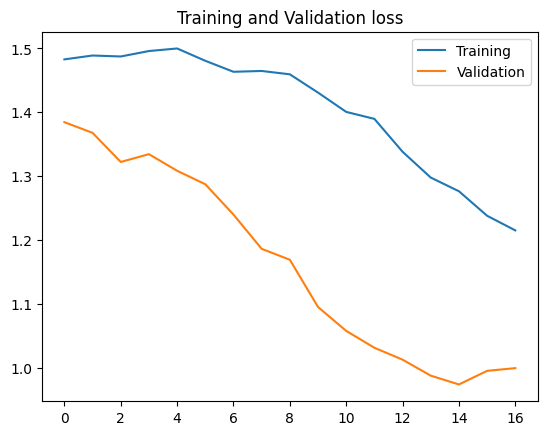

In [14]:
plot_loss(selected_model.train_loss, selected_model.val_loss)

## Test Performance

In [15]:
preds = selected_model.predict(X_test)
test_accuracy = accuracy_score(y_test, preds)

In [16]:
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Model: {type(selected_model)},\
        learning_rate: {selected_model.learning_rate},\
        epsilon: {selected_model.epsilon},\
        layers: {selected_model.layers if type(selected_model) is not Model1 else ''}")

Test accuracy: 43.48%
Model: <class 'src.Model2'>,        learning_rate: 1.2,        epsilon: 0.7,        layers: 2


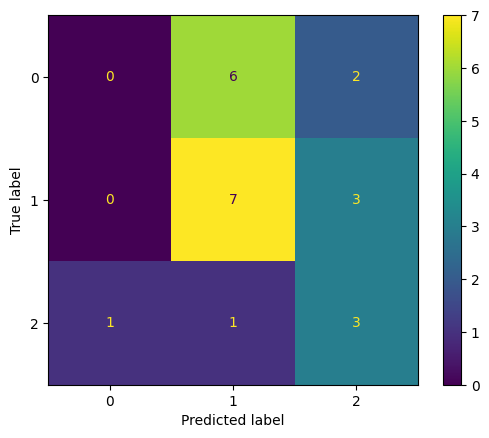

In [17]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.savefig("images/confusion_matrix.png")
plt.show()